In [45]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 

import matplotlib.pyplot as plt
import seaborn as sns

import random

import os

import tensorflow as tf
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Dense , Flatten, Conv2D, MaxPooling2D, Dropout, Input , BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2


In [26]:
path = str(path)
path
dataset_path = path + '\\pokemon-dataset-1000\\dataset'
train_path = path + '\\pokemon-dataset-1000\\train'
test_path = path + '\\pokemon-dataset-1000\\test'
val_path = path + '\\pokemon-dataset-1000\\val'


      Dataset Path: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\dataset
      Train Path: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\train
      Test Path: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\test
      Validation Path: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\val
      


In [33]:
label = [] # label of the image
path = [] # path of the image
main_dir = dataset_path
for i in os.listdir(main_dir):
    for img in os.listdir(f"{main_dir}/{i}"):
        label.append(i)
        path.append(f"{main_dir}/{i}/{img}")

In [34]:
df = pd.DataFrame(columns=['label', 'path'])
df['label'] = label
df['path'] = path

In [35]:
df.head()

,label,path
0,abomasnow,C:\Users\Aryan\.cache\kagglehub\datasets\noodu...
1,abomasnow,C:\Users\Aryan\.cache\kagglehub\datasets\noodu...
2,abomasnow,C:\Users\Aryan\.cache\kagglehub\datasets\noodu...
3,abomasnow,C:\Users\Aryan\.cache\kagglehub\datasets\noodu...
4,abomasnow,C:\Users\Aryan\.cache\kagglehub\datasets\noodu...


In [36]:
df.shape

(26539, 2)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   26539 non-null  object
 1   path    26539 non-null  object
dtypes: object(2)
memory usage: 414.8+ KB


In [38]:
df.nunique()

label     1000
path     26539
dtype: int64

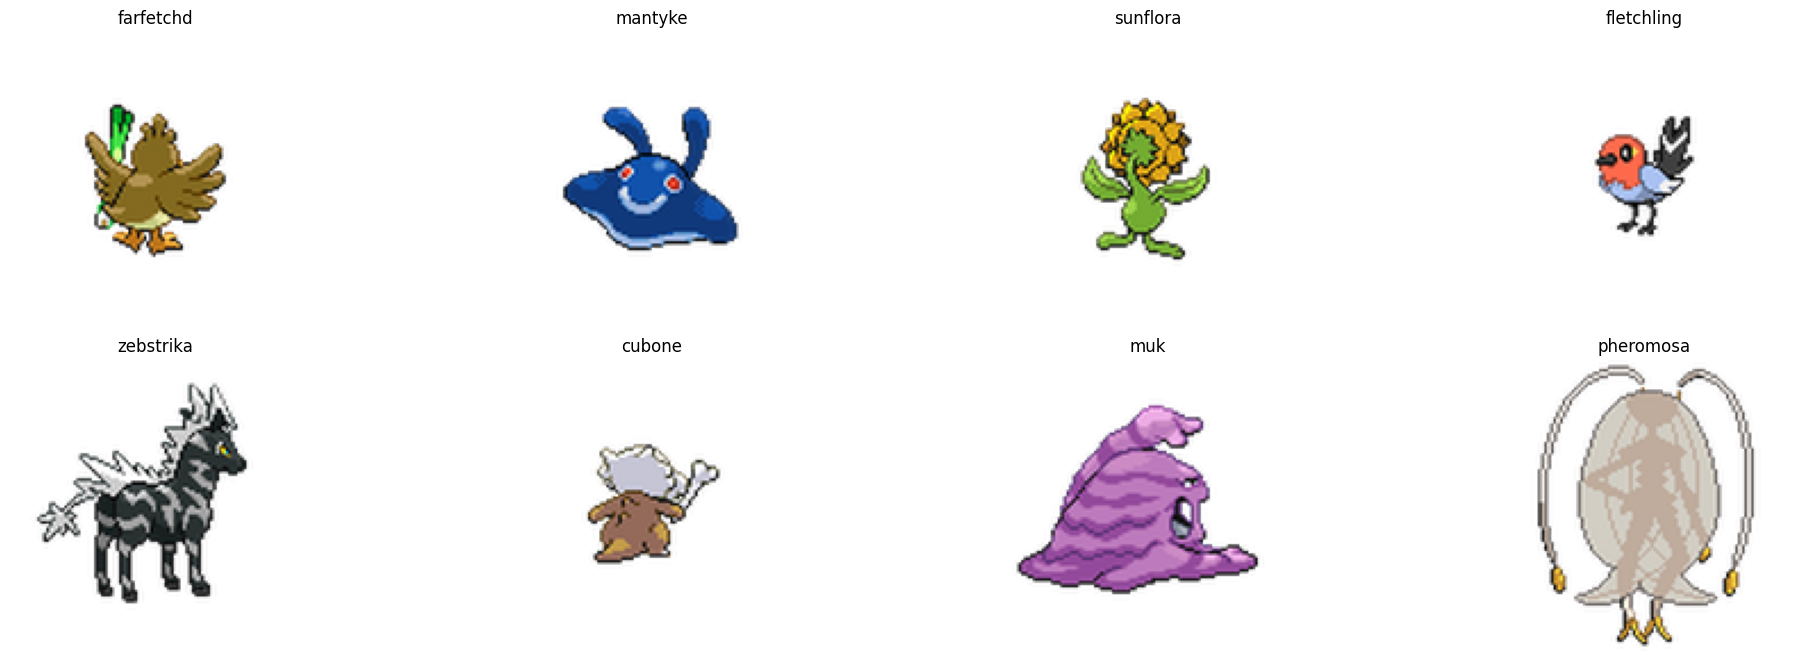

In [42]:
# displaying random pokemon images
rand_labels = random.sample(df['label'].unique().tolist(), 8)

plt.figure(figsize=(20, 10))
for idx, label in enumerate(rand_labels):
    plt.subplot(3, 4, idx + 1)
    img_path = df[df['label'] == label].iloc[0, 1]
    plt.imshow(plt.imread(img_path))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [47]:
# checking for image dimensions of random pokemon to confirm uniformity
from PIL import Image

rand_imgs = random.sample(list(df['path']), 1000)

img_shapes = []

for img_path in rand_imgs:
    img = Image.open(img_path)
    img_shapes.append(img.size)

widths, heights = zip(*img_shapes)

avg_shape = np.mean(widths), np.mean(heights)

print(f"Average image shape: {avg_shape}")

Average image shape: (128.0, 128.0)


In [48]:
df['label']

0         abomasnow
1         abomasnow
2         abomasnow
3         abomasnow
4         abomasnow
            ...    
26534    zygarde-50
26535    zygarde-50
26536    zygarde-50
26537    zygarde-50
26538    zygarde-50
Name: label, Length: 26539, dtype: object

In [49]:
# label encoding

labels = df['label'].astype('category').cat.codes 
df['label_encoded'] = labels

img_size = (128, 128)

images = []
for i in df['path']:
    img = load_img(i, target_size=img_size)
    img = img_to_array(img)
    img = img / 255.0 # Normalizing the pixel values (from 0 to 225 to 0 to 1)
    images.append(img)

X = np.array(images)
y = to_categorical(df['label_encoded'])

# .astype('category'): This converts the data type of the 'label' column to the Pandas category data type. 
# This is crucial because it tells Pandas to treat the values in this column as distinct categories, not just strings or numbers.  
# This step is important for the next operation.

# .cat.codes: This is the key part.  The .cat accessor is used specifically for columns of the category data type.  
# The .codes attribute returns a NumPy array of integers.  Each unique category in the original column is assigned a unique integer code.  
# These codes start from 0 and go up to the number of unique categories minus 1.

# labels = ...: Finally, the resulting NumPy array of integer codes is assigned to the variable labels.

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
print(f"X_train shape: {xtrain.shape}\nX_test shape: {xtest.shape}\nY_train shape: {ytrain.shape}\nY_test shape: {ytest.shape}")

X_train shape: (21231, 128, 128, 3)
X_test shape: (5308, 128, 128, 3)
Y_train shape: (21231, 1000)
Y_test shape: (5308, 1000)


In [54]:
ytrain = np.argmax(ytrain, axis=1) # converting one-hot encoded labels to categorical labels
ytest = np.argmax(ytest, axis=1) 

In [57]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# The selected code computes class weights for an imbalanced dataset and converts them into a dictionary
# using the dict(enumerate(class_weights)) function. The class weights are calculated using the compute_class_weight function

# ---------------------------------------------------------

# compute_class_weight:
# ----------------------
# Calculates weights for each class to handle class imbalance.
# class_weight='balanced' ensures weights are inversely proportional to class frequencies.
# classes=np.unique(y_train) provides unique class labels.
# y=y_train is the array of class labels.

# ---------------------------------------------------------

# dict(enumerate(class_weights)):
# ----------------------
# Converts the list of class weights into a dictionary where keys are class indices and values are the weights.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)
class_weights_dict = dict(enumerate(class_weights))

In [58]:
# model testing begins below